In [3]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from skimage import color
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

# Check for GPU
print("TensorFlow Version:", tf.__version__)

try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print("GPU:", gpus)
    else:
        print("CPU")
except:
    pass

TensorFlow Version: 2.18.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Hiperparámetros y config

In [37]:
# Dataset 
BASE_DATA_PATH = '/kaggle/input/stl10'

def find_subfolder(base, sub_name):
    for root, dirs, files in os.walk(base):
        if sub_name in dirs:
            return os.path.join(root, sub_name)
    return os.path.join(base, sub_name)

TRAIN_PATH = find_subfolder(BASE_DATA_PATH, "unlabeled_images")
VAL_PATH = find_subfolder(BASE_DATA_PATH, "train_images")
TEST_PATH = find_subfolder(BASE_DATA_PATH, "test_images")

print(f"Train Path: {TRAIN_PATH}")
print(f"Val Path: {VAL_PATH}")
print(f"Test Path: {TEST_PATH}")

IMG_SIZE = 128 
BATCH_SIZE = 64 
BUFFER_SIZE = 1000
LAMBDA = 10 

# Tamaños subset
SUBSET_SIZE_TRAIN = 20000 # Unlabeled 
SUBSET_SIZE_VAL = 1000    # Train 
SUBSET_SIZE_TEST = 8000   # Test 

Train Path: /kaggle/input/stl10/unlabeled_images
Val Path: /kaggle/input/stl10/train_images
Test Path: /kaggle/input/stl10/test_images


# 2. Cargamos y procesamos los datos

In [38]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image, channels=3)
    # RESIZE a 128x128
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0 
    return image

def rgb_to_lab(img_rgb):
    def _skimage_rgb2lab(x):
        # x is numpy array
        lab = color.rgb2lab(x)
        return lab.astype(np.float32)
    
    img_lab = tf.numpy_function(_skimage_rgb2lab, [img_rgb], tf.float32)
    return img_lab
    
def to_rgb(L, ab):
    L = (L + 1.0) * 50.0
    ab = ab * 128.0
    lab = np.concatenate([L, ab], axis=2)
    rgb = color.lab2rgb(lab)
    return rgb

def process_path(file_path):
    img_rgb = load_image(file_path)
    img_lab = rgb_to_lab(img_rgb)
    L = img_lab[:, :, 0:1] / 50.0 - 1.0
    ab = img_lab[:, :, 1:] / 128.0
    return L, ab

# Creamos los datasets
train_files = sorted(glob(os.path.join(TRAIN_PATH, "*.png")))
train_files = train_files[:SUBSET_SIZE_TRAIN]
print(f"{len(train_files)} imágenes de entrenamiento")

train_ds = tf.data.Dataset.from_tensor_slices(train_files)
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation
val_files = sorted(glob(os.path.join(VAL_PATH, "*.png")))
val_files = val_files[:SUBSET_SIZE_VAL]
print(f"{len(val_files)} imágenes para validación")

val_ds = tf.data.Dataset.from_tensor_slices(val_files)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Test Dataset 
test_files = sorted(glob(os.path.join(TEST_PATH, "*.png")))
test_files = test_files[:SUBSET_SIZE_TEST]
print(f"{len(test_files)} imágenes para test")

test_ds = tf.data.Dataset.from_tensor_slices(test_files)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

20000 imágenes de entrenamiento
1000 imágenes para validación
8000 imágenes para test


# 3. Generator (U-Net)

In [8]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 1]) 

    # 128x128 input
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), 
        downsample(128, 4), 
        downsample(256, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True), 
        upsample(256, 4), 
        upsample(128, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(2, 4, strides=2, padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 128, 128, 2)

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

generator = Generator()
generator.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64, 64,    │      1,024 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32, 32,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 16, 16,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 8, 8, 512) │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 4, 4, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 8, 8, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ sequential_5[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 16, 16,    │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ sequential_6[0][… │
│ (Concatenate)       │ 768)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 32, 32,    │  3,146,752 │ concatenate_1[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 384)              │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 64, 64,    │    786,944 │ concatenate_2[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 192)              │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 128,  │      6,146 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 2)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,480,322 (89.57 MB)

 Trainable params: 23,474,690 (89.55 MB)

 Non-trainable params: 5,632 (22.00 KB)

# 4. Discriminator

In [9]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 1], name="input_im")
    tar = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 2], name="target_im")

    x = layers.Concatenate()([inp, tar])

    # features
    down1 = downsample(64, 4, False)(x)   
    down2 = downsample(128, 4)(down1)       
    down3 = downsample(256, 4)(down2)       

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    # devuelve la salida + features
    return Model(
        inputs=[inp, tar],
        outputs=[last, [down1, down2, down3, leaky_relu]]
    )

discriminator = Discriminator()
discriminator.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_im            │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_im           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 128,  │          0 │ input_im[0][0],   │
│ (Concatenate)       │ 3)                │            │ target_im[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 64, 64,    │      3,072 │ concatenate_4[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 32, 32,    │    131,584 │ sequential_9[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │    525,312 │ sequential_10[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 18, 18,    │          0 │ sequential_11[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 15, 15,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │      2,048 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 17, 17,    │          0 │ leaky_re_lu_8[0]… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 14, 14, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,767,361 (10.56 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

# 5. Entrenamiento

In [27]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def feature_matching_loss(real_feats, fake_feats):
    loss = 0
    for fr, fg in zip(real_feats, fake_feats):
        loss += tf.reduce_mean(tf.abs(fr - fg))
    return loss

def generator_loss(disc_generated_output, gen_output, target,real_feats, fake_feats):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss  = tf.reduce_mean(tf.abs(target - gen_output))
    fm_loss  = feature_matching_loss(real_feats, fake_feats)

    total_gen_loss = gan_loss + (LAMBDA * l1_loss) + (LAMBDA * fm_loss)

    return total_gen_loss, gan_loss, l1_loss, fm_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss


generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [28]:
@tf.function
def train_step(L, target_ab):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        gen_output = generator(L, training=True)
        disc_real_out, real_feats = discriminator([L, target_ab], training=True)
        disc_fake_out, fake_feats = discriminator([L, gen_output], training=True)
        # loss generador (GAN + L1 + FM)
        gen_total_loss, gan_loss, l1_loss, fm_loss = generator_loss(
            disc_fake_out, gen_output, target_ab, real_feats, fake_feats
        )
        # loss discriminador
        disc_loss = discriminator_loss(disc_real_out, disc_fake_out)

    gen_grads = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return gen_total_loss, disc_loss

def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [
        to_rgb(test_input[0].numpy(), tar[0].numpy()),
        to_rgb(test_input[0].numpy(), prediction[0].numpy())
    ]
    title = ['Real', 'Predicted']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

def train(train_ds, epochs, val_ds):
    for epoch in range(epochs):
        
        # losses
        gen_losses = []
        disc_losses = []

        for input_image, target in tqdm(train_ds, desc=f"Epoch {epoch+1}/{epochs}"):
            gen_loss, disc_loss = train_step(input_image, target)
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)
        
        # Calculate avergae
        avg_gen_loss = tf.reduce_mean(gen_losses)
        avg_disc_loss = tf.reduce_mean(disc_losses)
        print(f"Epoch {epoch+1} Loss - Generator: {avg_gen_loss:.4f}, Discriminator: {avg_disc_loss:.4f}")
        
        if (epoch + 1) % 5 == 0:
            for example_input, example_target in val_ds.take(1):
                generate_images(generator, example_input, example_target)


Epoch 1/50: 100%|██████████| 313/313 [01:53<00:00,  2.75it/s]


Epoch 1 Loss - Generator: 12.4886, Discriminator: 1.3138


Epoch 2/50: 100%|██████████| 313/313 [01:50<00:00,  2.83it/s]


Epoch 2 Loss - Generator: 13.5281, Discriminator: 1.2654


Epoch 3/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 3 Loss - Generator: 13.9053, Discriminator: 1.2356


Epoch 4/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 4 Loss - Generator: 14.0981, Discriminator: 1.2357


Epoch 5/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 5 Loss - Generator: 14.0840, Discriminator: 1.2298


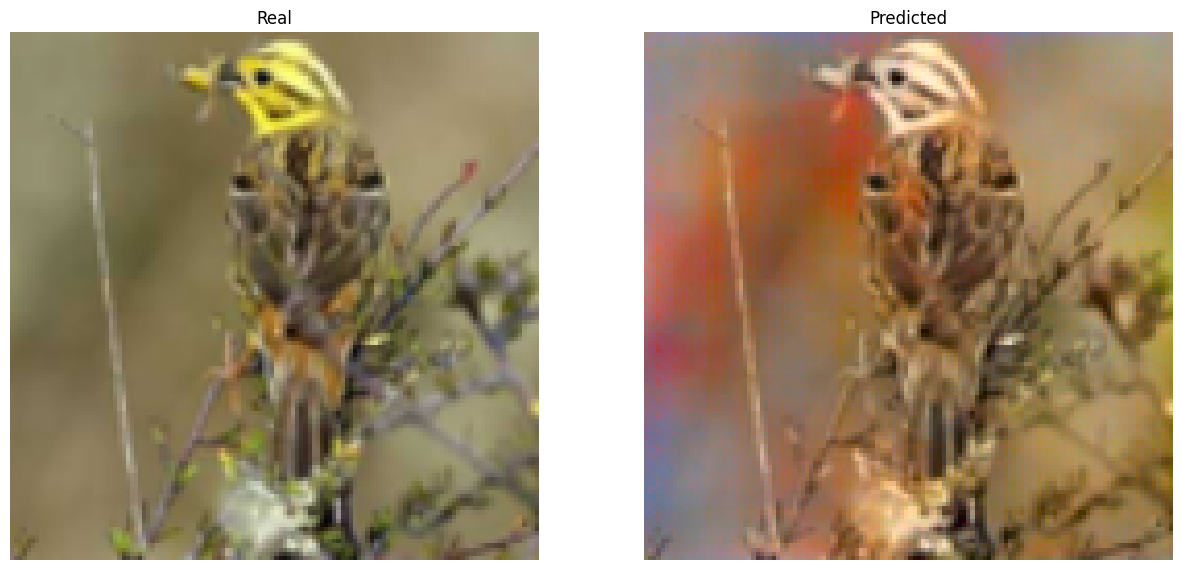

Epoch 6/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 6 Loss - Generator: 14.0659, Discriminator: 1.2108


Epoch 7/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 7 Loss - Generator: 13.9936, Discriminator: 1.2058


Epoch 8/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 8 Loss - Generator: 13.9570, Discriminator: 1.2123


Epoch 9/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 9 Loss - Generator: 13.7816, Discriminator: 1.2151


Epoch 10/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 10 Loss - Generator: 13.6183, Discriminator: 1.2146


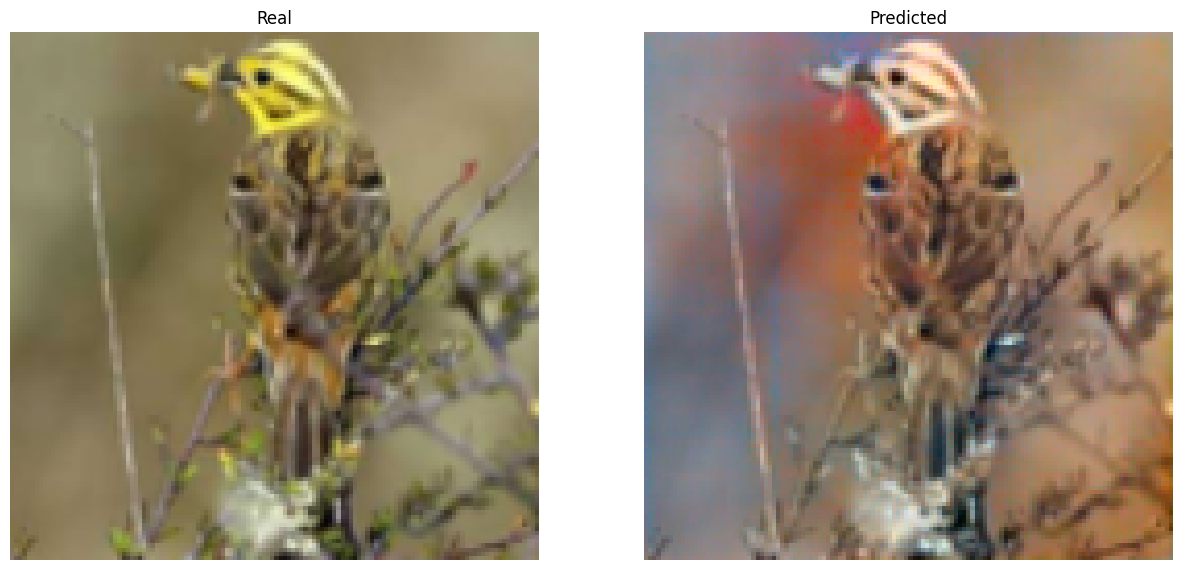

Epoch 11/50: 100%|██████████| 313/313 [01:50<00:00,  2.83it/s]


Epoch 11 Loss - Generator: 13.4234, Discriminator: 1.1971


Epoch 12/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 12 Loss - Generator: 13.1573, Discriminator: 1.1963


Epoch 13/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 13 Loss - Generator: 12.9955, Discriminator: 1.1943


Epoch 14/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 14 Loss - Generator: 12.8009, Discriminator: 1.1773


Epoch 15/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 15 Loss - Generator: 12.5634, Discriminator: 1.1736


/tmp/ipykernel_47/1880549580.py:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 23 negative Z values that have been clipped to zero
  rgb = color.lab2rgb(lab)


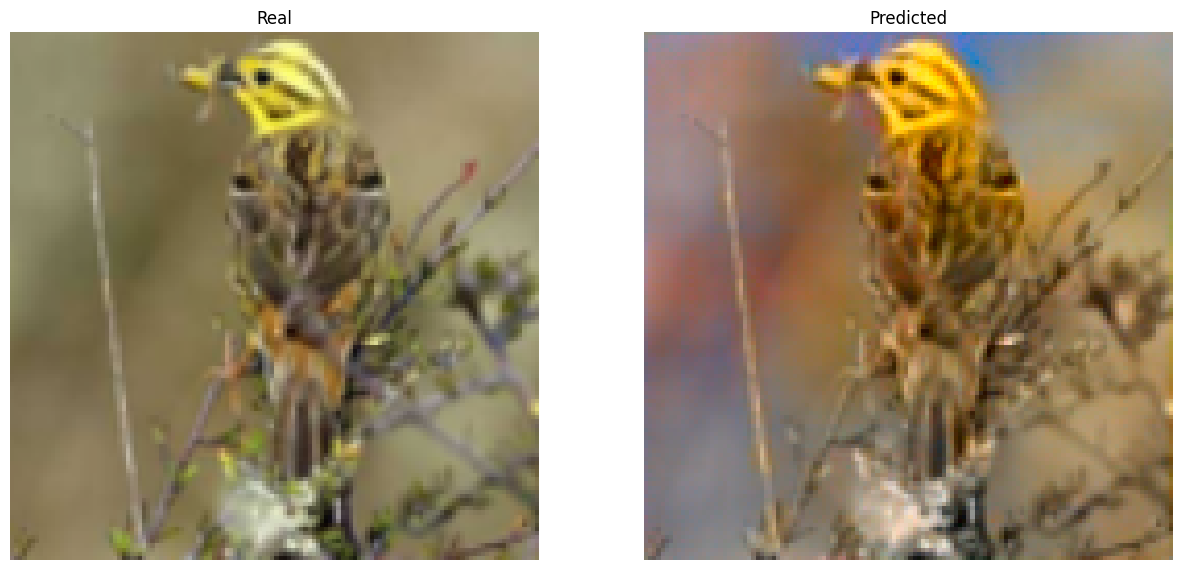

Epoch 16/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 16 Loss - Generator: 12.3515, Discriminator: 1.1664


Epoch 17/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 17 Loss - Generator: 12.1337, Discriminator: 1.1640


Epoch 18/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 18 Loss - Generator: 11.8869, Discriminator: 1.1608


Epoch 19/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 19 Loss - Generator: 11.6149, Discriminator: 1.1510


Epoch 20/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 20 Loss - Generator: 11.4551, Discriminator: 1.1443


/tmp/ipykernel_47/1880549580.py:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5 negative Z values that have been clipped to zero
  rgb = color.lab2rgb(lab)


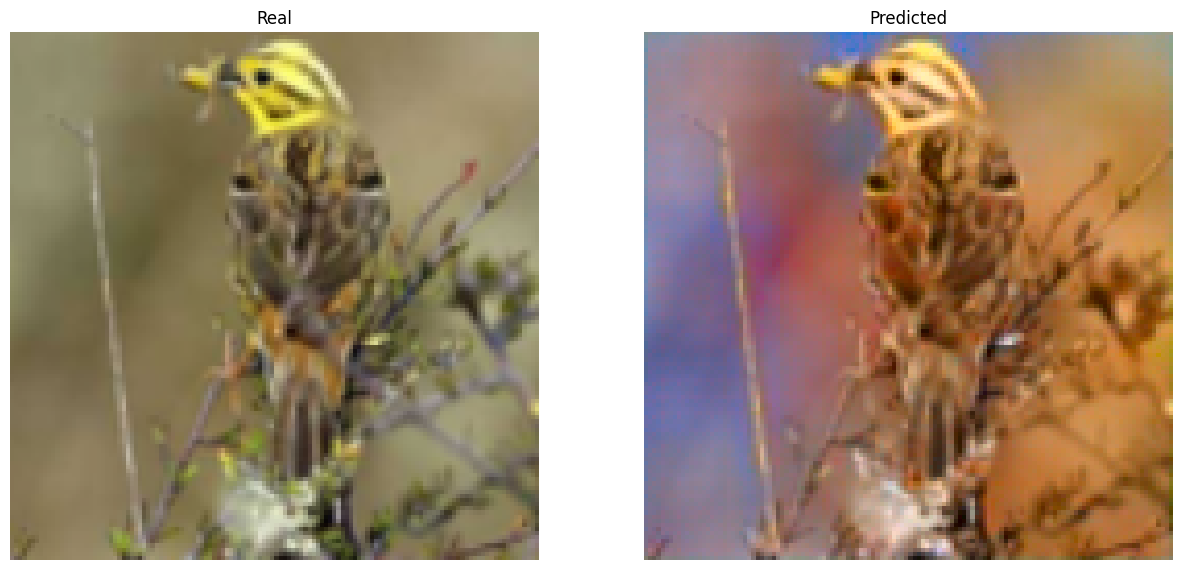

Epoch 21/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 21 Loss - Generator: 11.2494, Discriminator: 1.1438


Epoch 22/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 22 Loss - Generator: 11.1025, Discriminator: 1.1164


Epoch 23/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 23 Loss - Generator: 10.9200, Discriminator: 1.1302


Epoch 24/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 24 Loss - Generator: 10.7348, Discriminator: 1.1403


Epoch 25/50: 100%|██████████| 313/313 [01:50<00:00,  2.83it/s]


Epoch 25 Loss - Generator: 10.6367, Discriminator: 1.1175


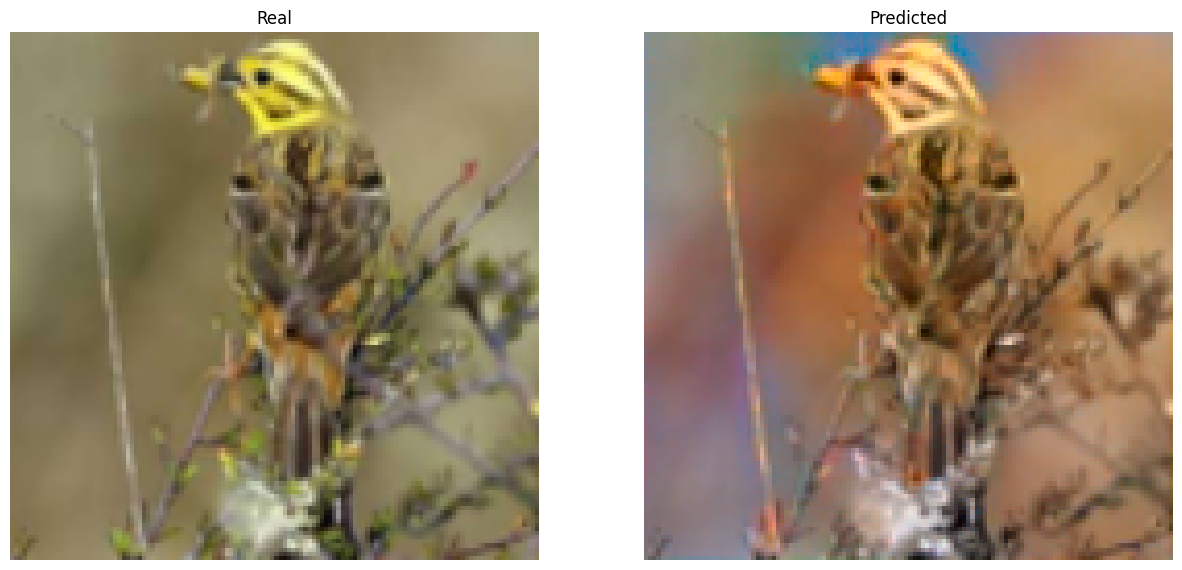

Epoch 26/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 26 Loss - Generator: 10.4978, Discriminator: 1.1270


Epoch 27/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 27 Loss - Generator: 10.4106, Discriminator: 1.1282


Epoch 28/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 28 Loss - Generator: 10.3106, Discriminator: 1.1329


Epoch 29/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 29 Loss - Generator: 10.2007, Discriminator: 1.1225


Epoch 30/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 30 Loss - Generator: 10.1135, Discriminator: 1.1278


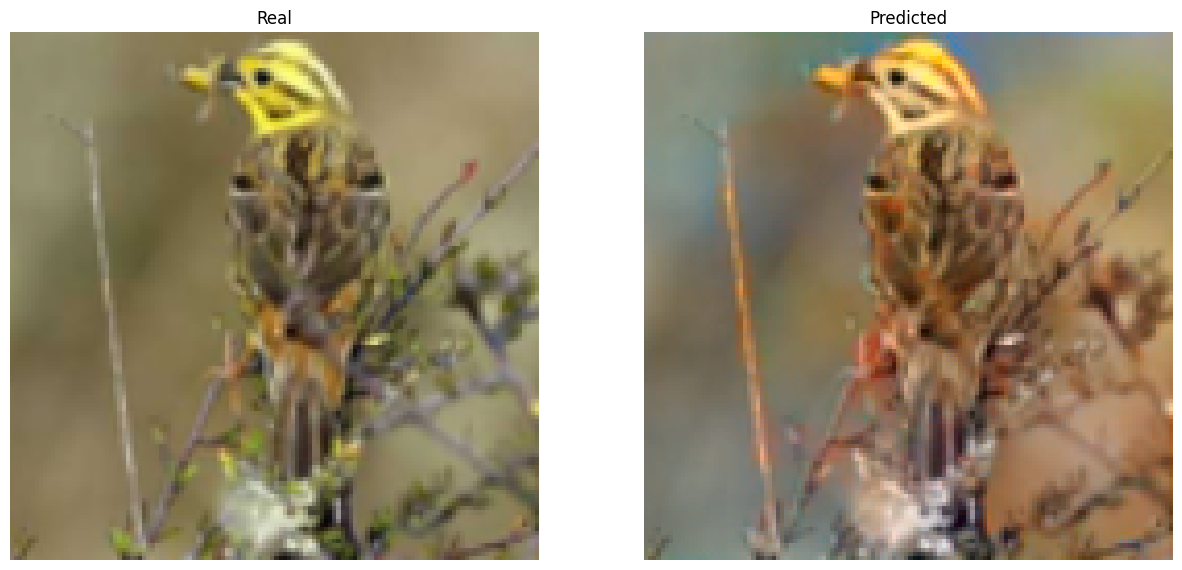

Epoch 31/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 31 Loss - Generator: 10.0147, Discriminator: 1.1453


Epoch 32/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 32 Loss - Generator: 9.9643, Discriminator: 1.1181


Epoch 33/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 33 Loss - Generator: 9.8116, Discriminator: 1.1464


Epoch 34/50: 100%|██████████| 313/313 [01:50<00:00,  2.85it/s]


Epoch 34 Loss - Generator: 9.7533, Discriminator: 1.1565


Epoch 35/50: 100%|██████████| 313/313 [01:50<00:00,  2.82it/s]


Epoch 35 Loss - Generator: 9.6598, Discriminator: 1.1467


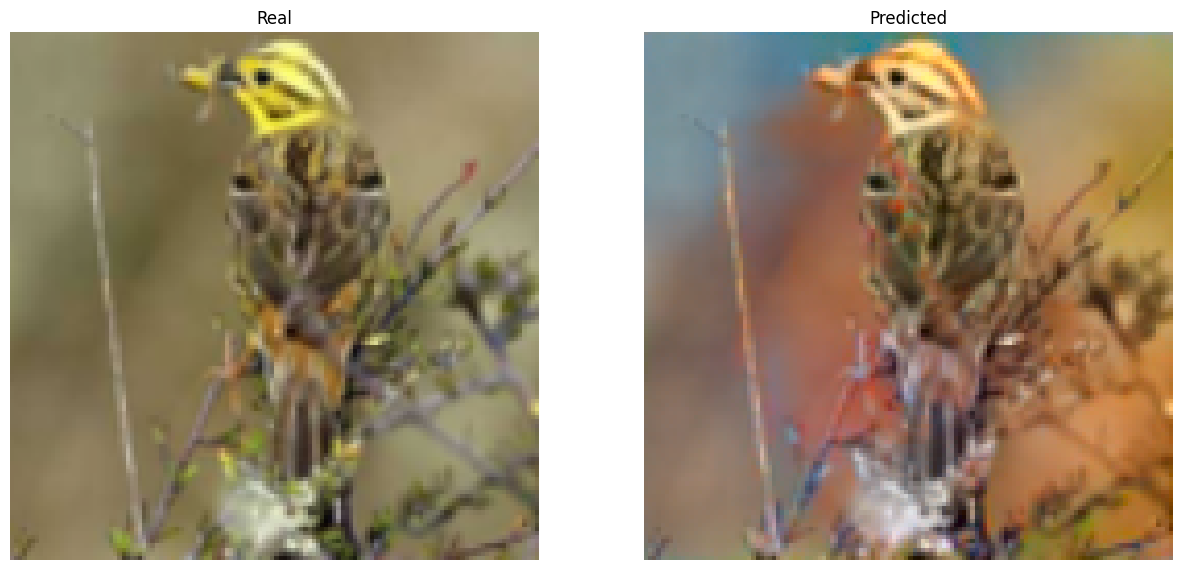

Epoch 36/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 36 Loss - Generator: 9.6367, Discriminator: 1.1749


Epoch 37/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 37 Loss - Generator: 9.5603, Discriminator: 1.1310


Epoch 38/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 38 Loss - Generator: 9.5213, Discriminator: 1.1326


Epoch 39/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 39 Loss - Generator: 9.3961, Discriminator: 1.2072


Epoch 40/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 40 Loss - Generator: 9.3337, Discriminator: 1.1391


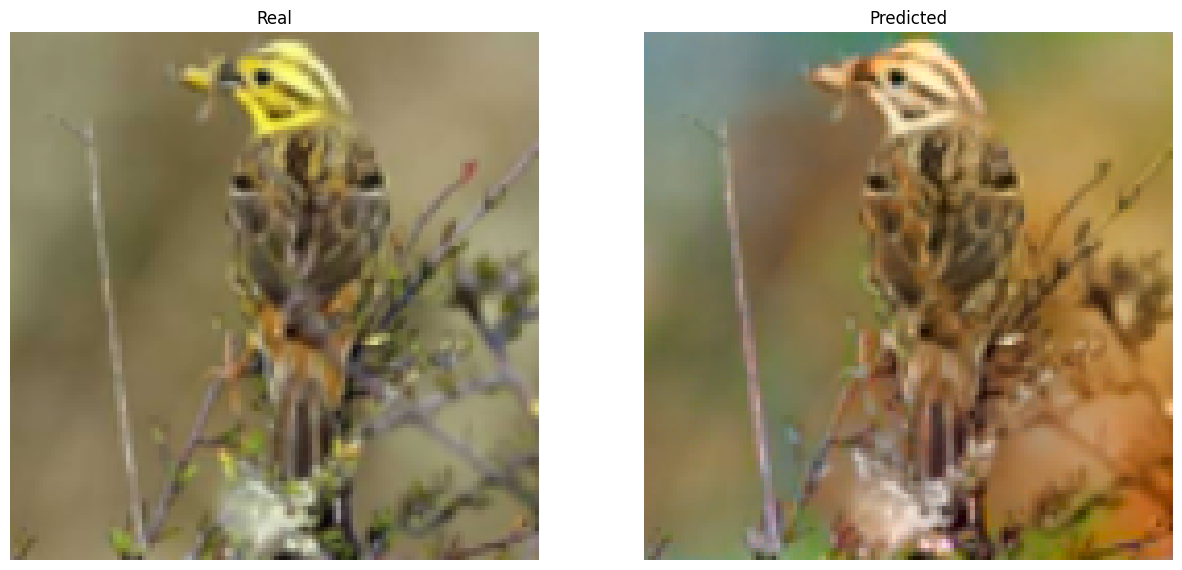

Epoch 41/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 41 Loss - Generator: 9.2866, Discriminator: 1.1568


Epoch 42/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 42 Loss - Generator: 9.2336, Discriminator: 1.1467


Epoch 43/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 43 Loss - Generator: 9.1879, Discriminator: 1.1713


Epoch 44/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 44 Loss - Generator: 9.1438, Discriminator: 1.1613


Epoch 45/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 45 Loss - Generator: 9.0863, Discriminator: 1.1623


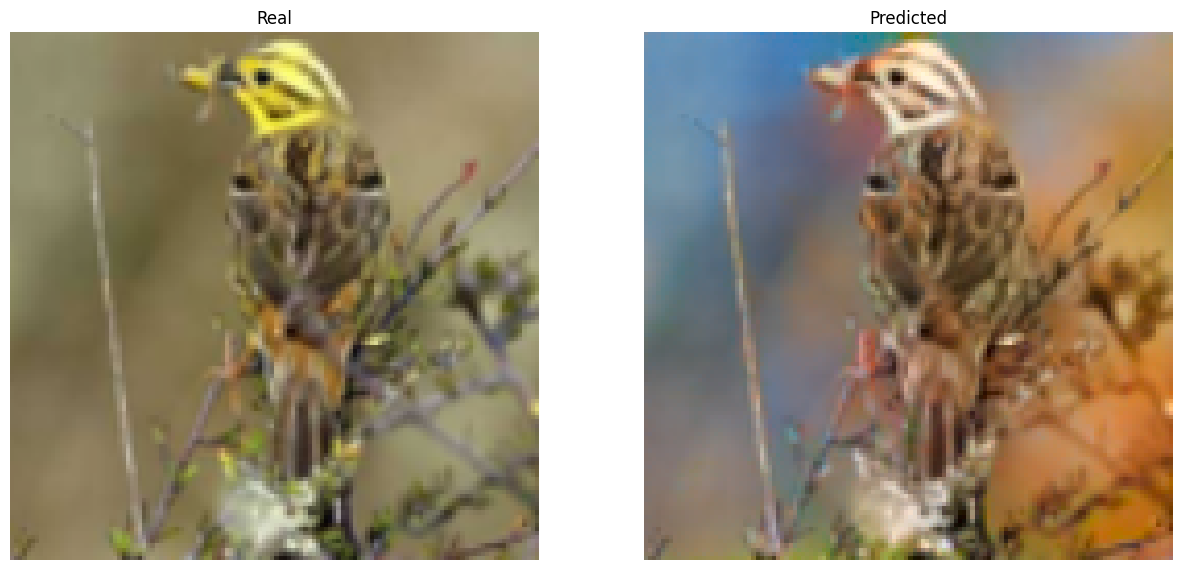

Epoch 46/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 46 Loss - Generator: 9.0468, Discriminator: 1.1630


Epoch 47/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 47 Loss - Generator: 9.0180, Discriminator: 1.1492


Epoch 48/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 48 Loss - Generator: 8.9592, Discriminator: 1.1594


Epoch 49/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 49 Loss - Generator: 8.8385, Discriminator: 1.2161


Epoch 50/50: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 50 Loss - Generator: 8.8321, Discriminator: 1.1588


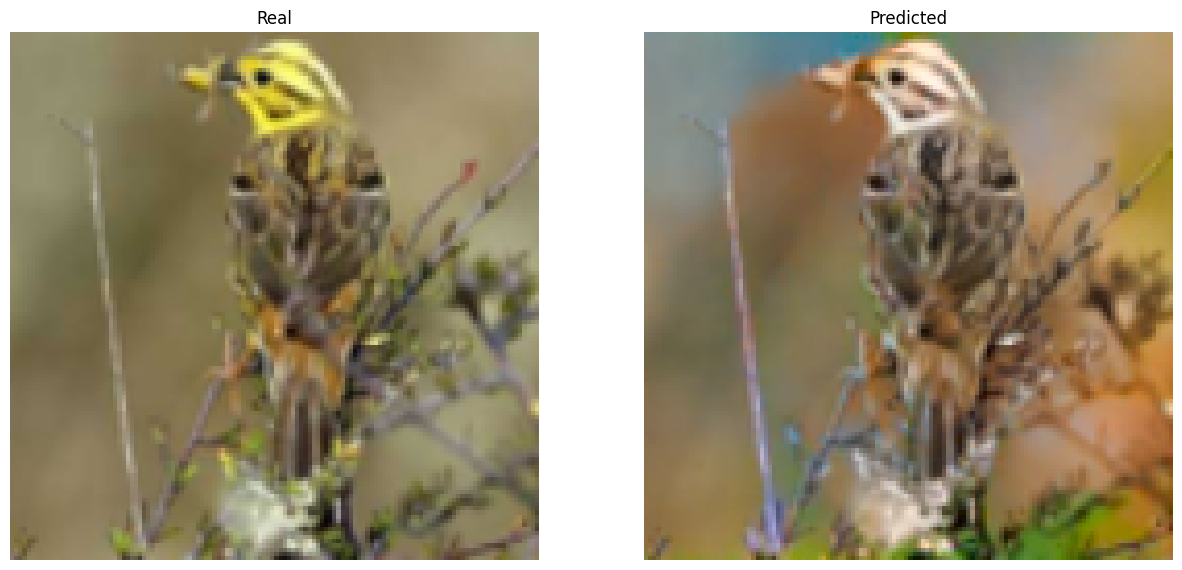

In [30]:
train(train_ds, 50, val_ds)

In [45]:
generator.save('c_gan_generator.h5')

In [39]:
import torch
import lpips
device_torch = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lpips_model = lpips.LPIPS(net='alex').to(device_torch)
lpips_model.eval()

def compute_lpips_torch(img1, img2):
    # Convert to Tensor
    t1 = torch.tensor(img1).permute(2,0,1).unsqueeze(0).float()
    t2 = torch.tensor(img2).permute(2,0,1).unsqueeze(0).float()

    # Normalizacion a [-1, 1]
    t1 = t1 * 2 - 1
    t2 = t2 * 2 - 1

    t1 = t1.to(device_torch)
    t2 = t2.to(device_torch)

    with torch.no_grad():
        dist = lpips_model(t1, t2)

    return dist.item()


def evaluate_model(model, ds, num_samples=None):
    ssim_scores = []
    psnr_scores = []
    lpips_scores = []

    count = 0
    for L, ab in tqdm(ds):
        preds = model(L, training=False)

        for i in range(L.shape[0]):
            if num_samples and count >= num_samples:
                break

            real_rgb = to_rgb(L[i].numpy(), ab[i].numpy())
            pred_rgb = to_rgb(L[i].numpy(), preds[i].numpy())

            real_tensor = tf.expand_dims(real_rgb, 0)
            pred_tensor = tf.expand_dims(pred_rgb, 0)

            ssim = tf.image.ssim(real_tensor, pred_tensor, max_val=1.0)
            psnr = tf.image.psnr(real_tensor, pred_tensor, max_val=1.0)

            # LPIPS 
            lp = compute_lpips_torch(real_rgb, pred_rgb)

            ssim_scores.append(float(ssim.numpy()[0]))
            psnr_scores.append(float(psnr.numpy()[0]))
            lpips_scores.append(lp)

            count += 1

        if num_samples and count >= num_samples:
            break

    print(f"SSIM: {np.mean(ssim_scores):.4f}")
    print(f"PSNR: {np.mean(psnr_scores):.4f}")
    print(f"LPIPS: {np.mean(lpips_scores):.4f}")

    return np.mean(ssim_scores), np.mean(psnr_scores), np.mean(lpips_scores)
ssim, psnr,lpips = evaluate_model(generator,test_ds,8000)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_47/1880549580.py:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  rgb = color.lab2rgb(lab)
  2%|▏         | 3/125 [00:07<05:20,  2.63s/it]/tmp/ipykernel_47/1880549580.py:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 37 negative Z values that have been clipped to zero
  rgb = color.lab2rgb(lab)
/tmp/ipykernel_47/1880549580.py:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  rgb = color.lab2rgb(lab)
 10%|▉         | 12/125 [00:30<04:44,  2.52s/it]/tmp/ipykernel_47/1880549580.py:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6 negative Z values that have been clipped to zero
  rgb = color.lab2rgb(lab)
 10%|█         | 13/125 [00:32<04:41,  2.51s/it]/tmp/ipykernel_47/1880549580.py:22: UserWarning: 

SSIM: 0.9097
PSNR: 23.6826
LPIPS: 0.1628


## Ejemplos

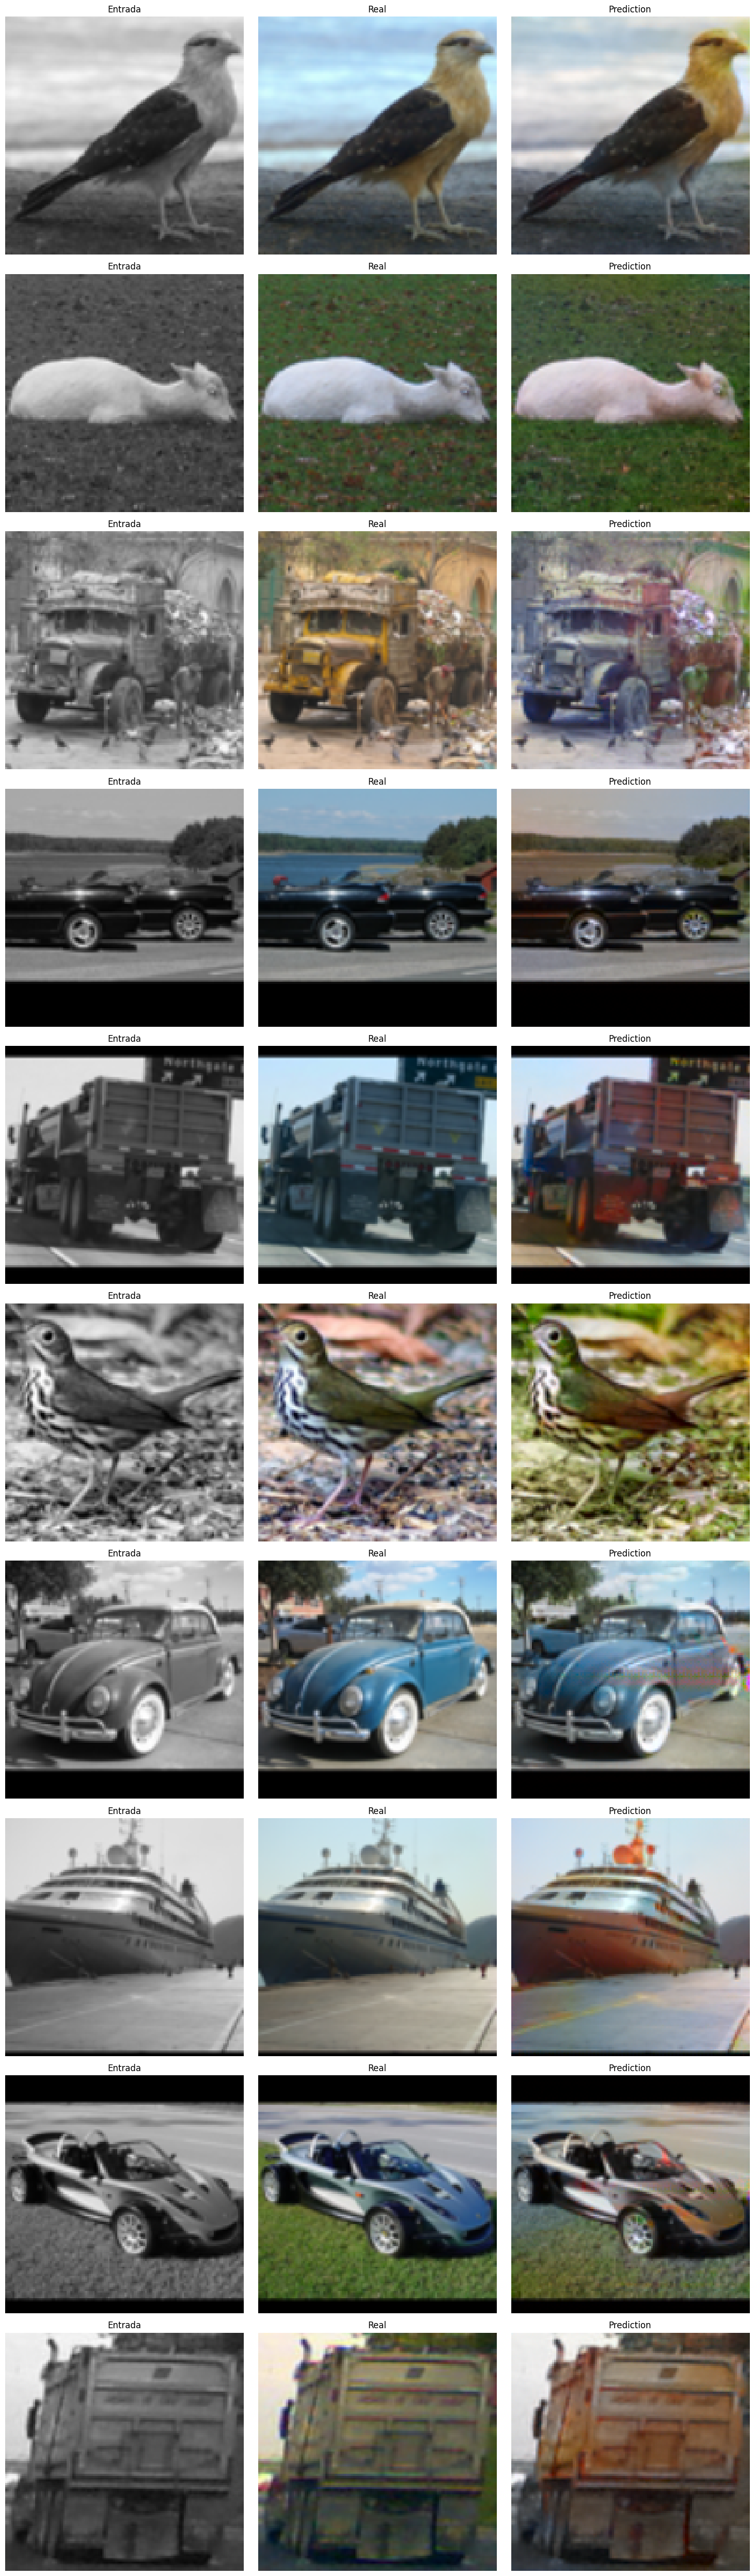

In [44]:
def show_examples(model, ds, num=10):
    plt.figure(figsize=(15, 5*num))

    batch = next(iter(ds.take(1)))
    L_batch, ab_batch = batch
    preds_batch = model(L_batch, training=False)
    
    for i in range(num):
        idx = np.random.randint(0, L_batch.shape[0])
        real = to_rgb(L_batch[idx].numpy(), ab_batch[idx].numpy())
        pred = to_rgb(L_batch[idx].numpy(), preds_batch[idx].numpy())
        gray = to_rgb(L_batch[idx].numpy(), np.zeros_like(ab_batch[idx].numpy()))

        plt.subplot(num, 3, i*3 + 1)
        plt.imshow(gray)
        plt.title("Entrada")
        plt.axis('off')

        plt.subplot(num, 3, i*3 + 2)
        plt.imshow(real)
        plt.title("Real")
        plt.axis('off')

        plt.subplot(num, 3, i*3 + 3)
        plt.imshow(pred)
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_examples(generator, test_ds, num=10)